In [ ]:
# import necessary libraries

import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

import time

print(tf.__version__)

2.3.0


In [ ]:
# read in train and test data in case Google DRIVE is used
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Basepath for Google DRIVE:
Basepath = '/content/drive/My Drive/Stage_ENT_Studios_2/Data/Kaggle/Arrays_5GB_float32/'

# Basepath for Jupyter notebooks:
# Basepath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data_FinalArrays/Kaggle/Array_10GB/'
# also a version with 5GB and 20GB

# test data
test_images = np.float32(np.load(Basepath + 'test_images_Final.npy'))
print('Shape test images: {}'.format(test_images.shape))

test_labels =  np.load(Basepath + 'test_labels_Final.npy')
print('Shape test labels: {}'.format(test_labels.shape))

Shape test images: (176, 512, 512, 3)
Shape test labels: (176, 2)


In [ ]:
# path to save the model and the tensorboard logs

# Basepath for Google DRIVE:
base_path = '/content/drive/My Drive/Stage_ENT_Studios_2/DR_Grading/Logs/'

# Basepath for jupyter notebooks:
# base_path = 'C:/Users/lunam/Documents/1steMaster/Stage/Code_Final/DR_classification/DeepLearningClassification/ResNet18_GPU/Logs/'

# direction where the tensorboard files will be stored
log_dir_tens = base_path + 'Tensorboard_Logs/'
# direction where the trained models will be stored
log_dir_model = base_path + 'Trained_Model/'

# Load the tensorboard extension. Tensorboard will be used to visualize the training and testing of the network
%load_ext tensorboard

In [ ]:
def Identity_Block(Input_Image, n_filters, dropout_prob = 0):


    # initialization of the weights
    W_init = tf.initializers.GlorotUniform()
    
    # Shortcut path: Identity function
    Shortcut_Image = Input_Image
    
    # Main path, Main_Image represents the image that is passed through different layers
    Main_Image = Input_Image

    Main_Image = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer= W_init, padding = 'same')(Main_Image) # padding is needed to keep the same dimensions
    Main_Image = tf.keras.layers.BatchNormalization(axis = 1)(Main_Image)
    Main_Image = tf.nn.relu(Main_Image)

    Main_Image = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer= W_init, padding = 'same')(Main_Image)
    
    # Output: Relu activation from (Shortcut path + Main path)
    Output_Image = tf.keras.layers.Add()([Main_Image, Shortcut_Image])

    if dropout_prob != 0:
        Output_Image = tf.keras.layers.Dropout(rate = dropout_prob)(Output_Image)

    Output_Image = tf.nn.relu(Output_Image)
    
    return Output_Image

In [ ]:
def Convolutional_Block(Input_Image, n_filters, dropout_prob = 0, pooling = False):
    

    # initialization of the weights
    W_init = tf.initializers.GlorotUniform()

    # Shortcut path
    Shortcut_Image = Input_Image
    Shortcut_Image = tf.keras.layers.Conv2D(n_filters, (3,3), strides = (2,2), kernel_initializer= W_init)(Shortcut_Image) # stride leads to a reduction in size
    Shortcut_Image = tf.keras.layers.BatchNormalization(axis = 1)(Shortcut_Image)

    # Main path
    Main_Image = Input_Image
    
    Main_Image = tf.keras.layers.Conv2D(n_filters, (3,3), strides = (2,2), kernel_initializer= W_init)(Main_Image)
    Main_Image = tf.keras.layers.BatchNormalization(axis = 1)(Main_Image)
    Main_Image = tf.nn.relu(Main_Image)

    Main_Image = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer= W_init, padding = 'same')(Main_Image) # padding is needed to keep the same dimensions
    Main_Image = tf.keras.layers.BatchNormalization(axis = 1)(Main_Image)


    # Output: Relu activation from (Shortcut path + Main path)
    Output_Image = tf.keras.layers.Add()([Main_Image, Shortcut_Image])

    if pooling:
        Output_Image = tf.keras.layers.MaxPool2D((2,2))(Output_Image)

    if dropout_prob != 0:
        Output_Image = tf.keras.layers.Dropout(rate = dropout_prob)(Output_Image)

    Output_Image = tf.nn.relu(Output_Image)
    
    return Output_Image

In [ ]:
def ResNet18(init_filters = 64, drop_prob = 0.1, dense_nodes = 1000, ExtraPooling = False):
    '''This function defines the original ResNet18 network'''
    
    # initialization of the weights
    W_init = tf.initializers.GlorotUniform()
    
    # Input
    X_Input = tf.keras.layers.Input(shape = (256,256, 3))
    
    # Convolutional layer 1
    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_Input)
    X = tf.keras.layers.Conv2D(init_filters, (7,7), strides=(2, 2), kernel_initializer= W_init)(X)
    X = tf.keras.layers.BatchNormalization(axis = 1)(X)
    X = tf.nn.relu(X)
    
    # Convolutional layer 2
    X = tf.keras.layers.ZeroPadding2D((1, 1))(X)
    X = tf.keras.layers.MaxPool2D((3,3), strides = (2,2))(X)
    X = Identity_Block(X, init_filters, dropout_prob = drop_prob)
    X = Identity_Block(X, init_filters, dropout_prob = 0)

    # Convolutional layer 3
    X = tf.keras.layers.ZeroPadding2D((1, 1))(X)
    X = Convolutional_Block(X, 2* init_filters, dropout_prob = drop_prob, pooling = ExtraPooling)
    X = Identity_Block(X, 2* init_filters, dropout_prob = 0)

    # Convolutional layer 4
    X = tf.keras.layers.ZeroPadding2D((1, 1))(X)
    X = Convolutional_Block(X,  4* init_filters, dropout_prob = drop_prob, pooling = ExtraPooling)
    X = Identity_Block(X, 4* init_filters, dropout_prob = 0)

    # Convolutional layer 5
    X = tf.keras.layers.ZeroPadding2D((1, 1))(X)
    X = Convolutional_Block(X, 8* init_filters, dropout_prob = drop_prob)
    X = Identity_Block(X, 8* init_filters, dropout_prob = 0)

    # Output layer
    X = tf.keras.layers.AveragePooling2D((2,2))(X)
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(dense_nodes, activation= tf.nn.relu)(X)
    X_Output = tf.keras.layers.Dense(2, activation= tf.nn.softmax)(X) # dense layer where the chance on benign and malignant is represented

    # define the model
    model = tf.keras.Model(inputs = X_Input, outputs = X_Output)
      
    return model

Visualize the training process with tensorboard

In [ ]:
# visualize the training results with tensorboard
# %tensorboard --logdir log_dir_tens

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
def Reload_and_Predict(TestImages, Drop_Prob = 0.1, Init_Filters = 64, Dense_Nodes = 1000, extra_pooling = False, 
                       log_dir_trained_model = log_dir_model, test_batch = 6, epochs = 10):
    '''This function reloads a trained model and predicts the annotations of images'''

    # Define the model for testing
    print('Define the model for testing')
    model = ResNet18(drop_prob = Drop_Prob, init_filters = Init_Filters, dense_nodes = Dense_Nodes, ExtraPooling = extra_pooling)

    # Load the stored weights of the trained model
    print('Restoring weight parameters...')
    model.load_weights(log_dir_trained_model + 'ResNet18_'+ str(epochs) +'_epochs')
    print('Model restored...')

    # predict the annotations for the test images
    print('Predicting the test cases...')

    all_pred_labels = []
    n_batches = int(TestImages.shape[0] / test_batch)
    if TestImages.shape[0] % test_batch != 0:
        print('Amount of test images is not dividable by the chosen test batch size!')
        print('Number of images: {}'.format(TestImages.shape[0]))
        print('Chosen batch size: {}'.format( test_batch))

    for i in range(n_batches):
        start = i*test_batch
        end = start + test_batch
        pred_labels = model(TestImages[start:end], training = False)
        pred_labels = np.array(pred_labels)

        if i == 0:
            all_pred_labels = pred_labels
        else:
            all_pred_labels = np.vstack((all_pred_labels, pred_labels))
    print('Test data predicted')
    
    # test_positive_prob gives the output probability map that can be used as an input to the test function
    return all_pred_labels

In [ ]:
predicted_labels = Reload_and_Predict(test_images, Drop_Prob = 0.1, Init_Filters = 64, 
                                     Dense_Nodes = 1000, extra_pooling = False, log_dir_trained_model = log_dir_model, test_batch = 8, epochs = 5)
# epochs are needed to define the name of the file to restore the model
# test batch has to be defined as a number through which the total amount of test images if dividable

Define the model for testing
Restoring weight parameters...
Model restored...
Predicting the test cases...
Test data predicted


Beneith some functions are indicated that can be used to evaluate the trained model. They are all brought together in the Evaluate funtion.

In [ ]:
def ROC(pred_probs, true_probs, plot = True):
    '''
    This function calculates the ROC-AUC value
    and it also calculates and visualizes the ROC-curve (if plot is true)
    '''
    
    # calculate and print out ROC-AUC value
    ROC_AUC = roc_auc_score(true_probs, pred_probs)
    
    # calculate and plot the ROC-curve
    if plot:
        FPRate, TPRate, Thresh = roc_curve(true_probs, pred_probs)
        plt.figure()
        plt.plot(FPRate, TPRate)
        plt.title('ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    return ROC_AUC

In [ ]:
def PRC(pred_probs, true_probs, plot = True):
    '''
    Calculate the aupr value = the area under the precision-recall curve
    and plot the precision-recall curve (if plot is true)
    '''
    
    # calculate the precision-recall curve
    Precision, Recall, Thresh = precision_recall_curve(true_probs, pred_probs)
    Precision = np.fliplr([Precision])[0]  # so the array is increasing (you won't get negative AUC)
    Recall = np.fliplr([Recall])[0]  # so the array is increasing (you won't get negative AUC)
    AUPR = np.trapz(Precision, Recall)
      
    
    # plot the precision-recall curve
    if plot:
        plt.figure()
        plt.plot(Precision, Recall)
        plt.title('Precision-Recall curve')
        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.show()
    
    return AUPR

In [ ]:
def ConfusionMatrix(pred_probs, true_probs, threshold_confusion = 0.5):
    '''
    Calculate and print out the confusion matrix
    The values for the confusion matrix are also returned
    A standard threhsold of 0.5 is used to calculate the confusion matrix
    '''
    # print out the threshold that is used for the confusion matrix
    print("Confusion matrix with a used threshold of {} for the positive class:".format(threshold_confusion))
    
    # turn the predicted probability maps into binary outputs according to the threshold
    thresh_pred_probs = np.empty((pred_probs.shape[0]))
    for i in range(pred_probs.shape[0]):
        if pred_probs[i] >= threshold_confusion:
            thresh_pred_probs[i] = 1
        else:
            thresh_pred_probs[i] = 0
    
    # calculate the confusion-matrix and print it out
    TN, FP, FN, TP = confusion_matrix(true_probs, thresh_pred_probs).ravel()
    print('Amount of true positives: {}'.format(TP))
    print('Amount of false positives: {}'.format(FP))
    print('Amount of true negatives: {}'.format(TN))
    print('Amount of false negatives: {}'.format(FN))
    
    return TN, FP, FN, TP

In [ ]:
def Metrics(tn, fp, fn, tp):
    '''Print out some metrics like the accuracy, specificity, sensitivity and precision'''
    
    print('Some metrics:')
    
    # print out accuracy
    accuracy = 0
    if (tn+fp+fn+tp) != 0:
        accuracy = (tp+tn)/(tn+fp+fn+tp)
    print('Accuracy: {}'.format(accuracy))
    
    # print out specificity
    specificity = 0
    if (tn+fp) != 0:
        specificity = tn/(tn+fp)
    print('Specificity: {}'.format(specificity))
    
    # print out sensitivity
    sensitivity = 0
    if (tp+fn) != 0:
        sensitivity = tp/(tp+fn)
    print('Sensitivity: {}'.format(sensitivity))
    
    # print out precision
    precision = 0
    if (tp+fp) != 0:
        precision = tp/(tp+fp)
    print('Precision: {}'.format(precision))


In [ ]:
# evaluation of the model
def Evaluate(pred_labels, true_labels):
    '''
    Evaluation of the network, based on comparisson between the true and predicted outputs
    '''
    print('Evaluating the model...')
    
    # creat a 1D numpy array with the predicted and true outputs
    pred_pos_probs = pred_labels[:,0]
    true_pos_probs = true_labels[:,0]

    # print out ROC-AUC value and plot the ROC-curve
    ROC_AUC = ROC(pred_pos_probs, true_pos_probs)
    print('Area under the ROC curve: {}'.format(ROC_AUC))

    # print out area under the precision-recall curve, AUPR value
    AUPR = PRC(pred_pos_probs, true_pos_probs)
    print('Area under Precision-Recall curve: {}'.format(AUPR))
    
    # print out confusion matrix
    TN, FP, FN, TP = ConfusionMatrix(pred_pos_probs, true_pos_probs)
    
    # print out some metrics
    Metrics(TN, FP, FN, TP)

Evaluating the model...


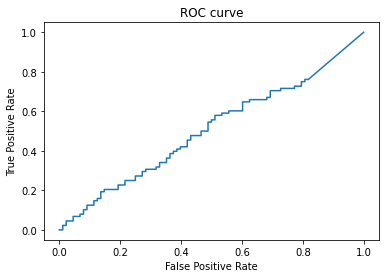

Area under the ROC curve: 0.5045196280991735


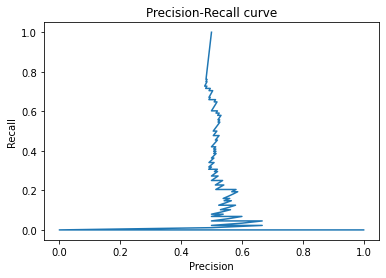

Area under Precision-Recall curve: 0.5110115032614497
Confusion matrix with a used threshold of 0.5 for the positive class:
Amount of true positives: 0
Amount of false positives: 0
Amount of true negatives: 88
Amount of false negatives: 88
Some metrics:
Accuracy: 0.5
Specificity: 1.0
Sensitivity: 0.0
Precision: 0


In [ ]:
Evaluate(predicted_labels , test_labels)

To kill an active tensorboard session:
Go to the anaconda prompt and type:

taskkill /im tensorboard.exe /f

del /q %TMP%\.tensorboard-info\*


or in the windows command prompt:

taskkill /IM "tensorboard.exe" /F